<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#AB-Testing" data-toc-modified-id="AB-Testing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>AB-Testing</a></span></li></ul></div>

# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem

import pylab as plt

In [2]:
# datos
data = pd.read_csv('data/cookie_cats.csv')
data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
# transformacion
ret1 = pd.crosstab(data.version, data.retention_1)
ret1

retention_1,False,True
version,,
gate_30,24666,20034
gate_40,25370,20119


In [5]:
ret7 = pd.crosstab(data.version, data.retention_7)
ret7

retention_7,False,True
version,,
gate_30,36198,8502
gate_40,37210,8279


In [27]:
# muestreo

imps_ctrl1, convs_ctrl1= len(data[data['version']=='gate_30']), len(data[(data['retention_1']==True) & (data['version']=='gate_30')])
imps_test1, convs_test1= len(data[data['version']=='gate_40']), len(data[(data['retention_1']==True) & (data['version']=='gate_40')])

CR_ctrl1=convs_ctrl1/imps_ctrl1
CR_test1=convs_test1/imps_test1

print(f'TASAS RET1: Control={CR_ctrl1}, Test={CR_test1}')

#----------------------------------------------

imps_ctrl7, convs_ctrl7= len(data[data['version']=='gate_30']), len(data[(data['retention_7']==True) & (data['version']=='gate_30')])
imps_test7, convs_test7= len(data[data['version']=='gate_40']), len(data[(data['retention_7']==True) & (data['version']=='gate_40')])

CR_ctrl7=convs_ctrl7/imps_ctrl7
CR_test7=convs_test7/imps_test7

print(f'TASAS RET7: Control={CR_ctrl7}, Test={CR_test7}')

TASAS RET1: Control=0.4481879194630872, Test=0.44228274967574577
TASAS RET7: Control=0.19020134228187918, Test=0.18200004396667327


In [28]:
# testeo para retention_1
from scipy.stats import bernoulli, beta  
#definición para los parámetro de las funciones beta de cada suceso

a_C, b_C = convs_ctrl1+1, imps_ctrl1-convs_ctrl1+1
a_T, b_T = convs_test1+1, imps_test1-convs_test1+1

beta_control=beta(a_C, b_C)
beta_test=beta(a_T, b_T)

In [35]:
x=np.linspace(0.43, 0.46, 1000)

def plot(betas, nombres, x):
    
    for bet, nom in zip(betas, nombres):
        
        y=bet.pdf(x)
        y_media=bet.mean()
        y_std=bet.std()
        
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(nom, y_media, y_std))
        plt.yticks([])
        
    plt.legend()
    plt.show();

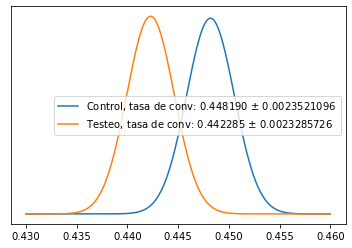

In [36]:
plot([beta_control, beta_test], ['Control', 'Testeo'], x)

In [37]:
salto=(beta_test.mean()-beta_control.mean())/beta_control.mean()

salto

-0.013175098158249857

In [51]:
from mpmath import betainc   # integral de beta

prob=beta.cdf(0.447, a_T, b_T)

prob=float(prob)

prob

0.9784948757822922

In [41]:
'''El test aumenta la tasa de conversion en un {:2.2f}%, con una probabilidad del {:2.2f}%'''.format(salto*100, prob*100)

'El test aumenta la tasa de conversion en un -1.32%, con una probabilidad del 87.81%'

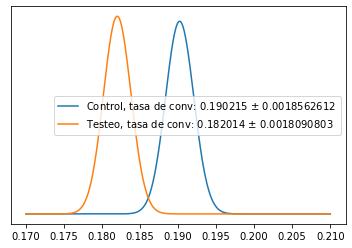

In [45]:
# testeo para retention_7

from scipy.stats import bernoulli, beta  
#definición para los parámetro de las funciones beta de cada suceso

a_C2, b_C2 = convs_ctrl7+1, imps_ctrl7-convs_ctrl7+1
a_T2, b_T2 = convs_test7+1, imps_test7-convs_test7+1

beta_control2=beta(a_C2, b_C2)
beta_test2=beta(a_T2, b_T2)

x2=np.linspace(0.17, 0.21, 1000)

plot([beta_control2, beta_test2], ['Control', 'Testeo'], x2)

In [46]:
salto2=(beta_test2.mean()-beta_control2.mean())/beta_test2.mean()

salto2

-0.04505794626660234

In [48]:
prob2=beta.cdf(0.186, a_T2, b_T2)

prob2=float(prob2)

prob2

0.98586530053145

In [49]:
f'El test aumenta la tasa de conversion en un {salto2}, con una probabilidad del {prob2}%'

'El test aumenta la tasa de conversion en un -0.04505794626660234, con una probabilidad del 0.98586530053145%'

In [52]:
# conclusiones
# En el único test que he encontrado alguna diferencia es en el primero de retention_1 , pues hay un salto de 1,32% 
# con una probabilidad del 97%.
# Sin embargo, en el segundo de retention_7 hay un salto minúsculo, pues la diferencia de medias es del 0.045...
# Por lo tanto, la gate que se debe tomar en retention_1 es la de gate_30 pues la retencion es mayor que en 30